In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from pytorch_lightning import LightningModule, Trainer
import kornia as K
from sklearn.model_selection import train_test_split

import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import os
import glob

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
list_train = glob.glob('TrainIJCNN2013/TrainIJCNN2013' + '/*')
list_train = [string.split('/')[-1] for string in list_train if '.ppm' in string]
len(list_train), list_train[0]

(600, '00316.ppm')

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    # x_min, y_min, w, h = bbox
    bbox = [int(i) for i in bbox]
    x_min, y_min, x_max, y_max = bbox
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(str(class_name), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=str(class_name),
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name=None):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        if category_id_to_name:
            class_name = category_id_to_name[category_id]
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('TrainIJCNN2013/TrainIJCNN2013/gt.txt', sep=';', header=None)
data.rename(columns={0: "image", 5: "class"}, inplace=True)
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


<AxesSubplot:ylabel='Frequency'>

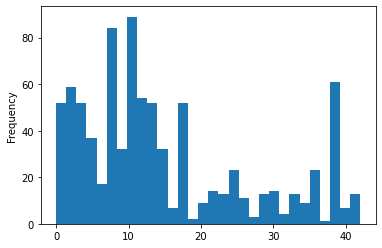

In [7]:
data['class'].plot.hist(bins=30)

In [8]:
data[data['image'] == '00001.ppm']

,image,1,2,3,4,class
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13


In [9]:
# data.drop(data[(data['class'] == 41) | (data['class'] == 42)].index, inplace=True)
# data.reset_index(drop=True, inplace=True)
# data

In [10]:
# data[data['class'] == 32].head() # 12, 14, 17, 41 ,42

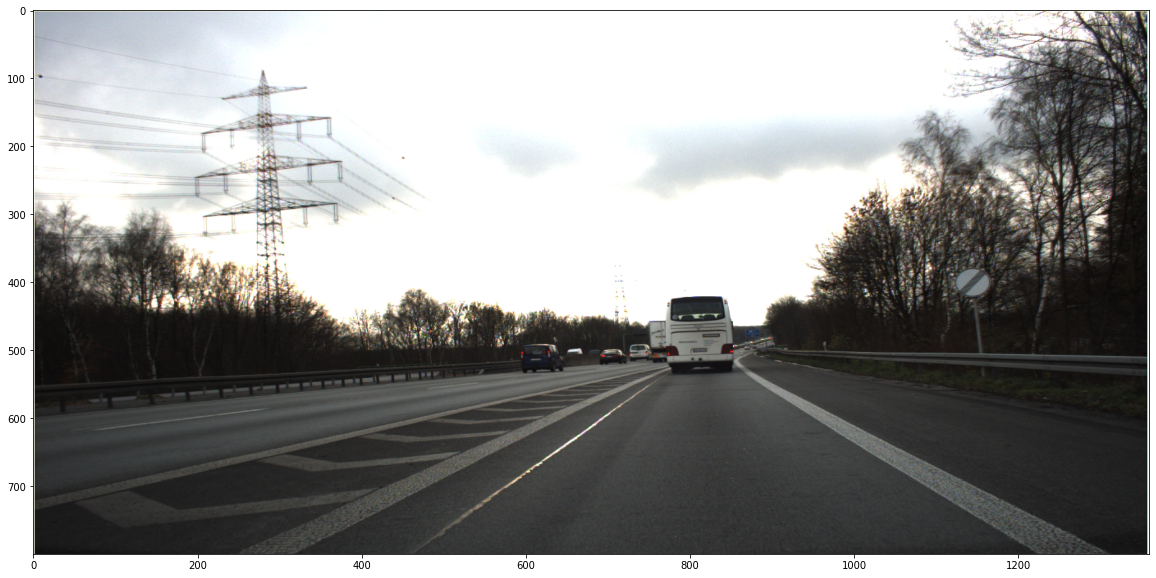

In [11]:
im = cv2.imread('TrainIJCNN2013/TrainIJCNN2013/00317.ppm')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (20,10))
plt.imshow(im, aspect='auto')

In [12]:
def get_label(label):
    prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]  # (circular, white ground with red border)
    mandatory = [33, 34, 35, 36, 37, 38, 39, 40]  # (circular, blue ground)
    danger = [11, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]  # (triangular, white ground with red border)
    # rare = [12, 14, 17, 41 ,42] 

    if label in prohibitory:
        new_label = 0
    elif label in mandatory:
        new_label = 1
    elif label in danger:
        new_label = 2
    else:
        new_label = 3

    return new_label

In [13]:
data['class'] = data['class'].apply(get_label)

In [14]:
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,2
1,00001.ppm,983,388,1024,432,1
2,00001.ppm,386,494,442,552,1
3,00001.ppm,973,335,1031,390,2
4,00002.ppm,892,476,1006,592,1


In [15]:
ser = data[data['image'] == '00001.ppm']

In [16]:
for index, row in ser.iterrows():
    print(index)
    print(row['image'])


1
00001.ppm
2
00001.ppm
3
00001.ppm


<AxesSubplot:ylabel='Frequency'>

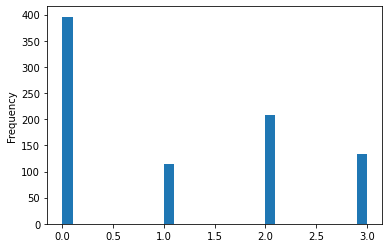

In [17]:
data['class'].plot.hist(bins=30)

In [18]:
stratify = data['class'].value_counts().values
stratify = stratify/stratify.sum()
stratify

array([0.46478873, 0.24413146, 0.157277  , 0.13380282])

In [19]:
train, val = train_test_split(data, test_size=0.2, stratify=data['class'])

In [20]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [21]:
train

,image,1,2,3,4,class
0,00179.ppm,686,421,707,440,3
1,00051.ppm,968,218,1037,287,3
2,00406.ppm,1046,503,1097,551,2
3,00552.ppm,538,528,554,544,0
4,00360.ppm,253,502,296,545,0
...,...,...,...,...,...,...
676,00428.ppm,325,548,353,576,0
677,00316.ppm,994,395,1022,420,2
678,00475.ppm,1233,468,1310,543,0
679,00314.ppm,396,451,429,485,0


In [23]:
transform = A.Compose([
    A.Resize(width=640, height=480),
    # A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [24]:
# train_transform = A.Compose([
#     # A.OneOf([
#     A.RandomSizedBBoxSafeCrop(width=640, height=480, p=1),
#     # A.RandomCrop(width=640, height=480, p=1),
# # ]),
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.3),
#     A.VerticalFlip(p=0.3),
#     A.RandomBrightnessContrast(p=0.3),
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))
# val_transform = A.Compose([
#     A.RandomCrop(width=640, height=480, p=1),

#     A.RandomBrightnessContrast(p=0.5),
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [25]:
class DetectionDataset(Dataset):
    def __init__(self, data, root, transforms = None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.names = data['image'].unique()

    def __getitem__(self, idx):
        name = self.names[idx]
        df = self.data[self.data['image'] == name]
        img_path = os.path.join(self.root, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        bboxes = []
        labels = []
        # print(df)
        for index, row in df.iterrows():
            # print(row)
            bboxes.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])
            labels.append(row['class'])

        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=bboxes, category_ids=labels)
            img = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['category_ids']
        target = {}
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        # target["boxes"] = bboxes
        # target["labels"] = labels
        img = torch.as_tensor(img).float().permute(2,0,1)
        return img, target
        # return img, bboxes, labels

    def __len__(self):
        return len(self.names)

def collate_fn(batch):
    return tuple(zip(*batch))

In [26]:
train_set = DetectionDataset(train, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)
val_set = DetectionDataset(val, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)


In [27]:
im, targets = train_set[2]

In [28]:
im.max()

tensor(238.)

In [29]:
im.shape, targets

(torch.Size([3, 480, 640]),
 {'boxes': tensor([[492.2353, 301.8000, 516.2353, 330.6000],
          [244.7059, 332.4000, 259.2941, 348.6000],
          [133.6471, 308.4000, 156.7059, 335.4000]]),
  'labels': tensor([2, 2, 2])})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


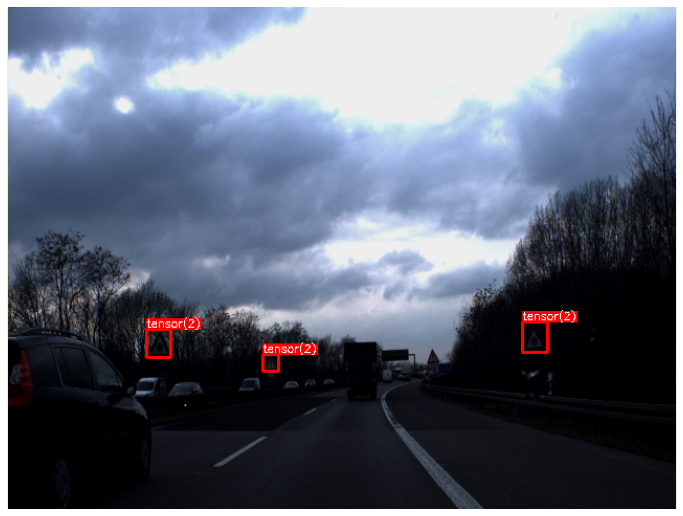

In [30]:
visualize(im.permute(1,2,0).numpy() / 255., targets['boxes'], targets['labels'])

In [31]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [32]:
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 4  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [33]:
data_loader = torch.utils.data.DataLoader(
 train_set, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn,
 )
val_loader = torch.utils.data.DataLoader(
 val_set, batch_size=2, num_workers=4, collate_fn=collate_fn,
 )


In [34]:
images,targets = next(iter(data_loader))

In [35]:
len(images)

2

In [36]:
# # imges = list(torch.as_tensor(image).permute(2, 0 , 1).long() / 255. for image in images)
# imges = list(image.long() / 255. for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# model.train()
# output = model(imges, targets)   # Returns losses and detections
# # For inference
# model.eval()
# # x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(imges)
# print('targets: ', targets)
# print('output: ', output)
# print('predictions: ', predictions)

In [37]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [38]:
# metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
# metric.update(predictions, targets)
# metric.compute()

In [55]:
class FasterRCNN(LightningModule):
    def __init__(self,n_classes):
        super().__init__()
        self.detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        self.detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        self.lr = 1e-3
        self.metric = MeanAveragePrecision()

    def forward(self, imgs,targets=None):
      # Torchvision FasterRCNN returns the loss during training 
      # and the boxes during eval
      self.detector.eval()
      return self.detector(imgs)

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
      return optimizer

    def training_step(self, batch, batch_idx):
      images,targets = batch
      targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

      # fasterrcnn takes both images and targets for training, returns
      loss_dict = self.detector(images, targets)
      loss = sum(loss for loss in loss_dict.values())
      self.log('train_loss_step', loss.detach(), on_step=True)
      return {"loss": loss, "log": loss_dict}

    def validation_step(self, batch, batch_idx):
      img, boxes = batch
      pred_boxes =self.forward(img)
      self.val_loss = self.metric(pred_boxes, boxes)
      self.log('val_step', self.val_loss['map'], on_step=True)
      # print('step', self.val_loss['map'])
      return {"val_loss": self.val_loss['map']}

    def validation_epoch_end(self, outputs):
      loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
      log_dict = {"val_loss": loss_val.detach()}
      # Логи валидационных эпох для tensorboard
      self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)
      # print('epoch', log_dict['val_loss'])
      return log_dict['val_loss']

In [56]:
# det_model = Detection_model()
det_model = FasterRCNN(4)

In [57]:
# det_model = det_model.load_from_checkpoint(checkpoint_path='lightning_logs/epoch=1-step=453.ckpt', n_classes=4)

In [58]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [59]:
checkpoint_callback = ModelCheckpoint(dirpath=f"lightning_logs/detection/new", save_top_k=2, monitor="val_epoch_total_step", mode='max')

In [60]:
# det_model = det_model.load_from_checkpoint(checkpoint_path='lightning_logs/epoch=1-step=453.ckpt', n_classes=4)
# det_model = det_model.load_from_checkpoint(checkpoint_path='lightning_logs/detection/epoch=1-step=441.ckpt', n_classes=4)

In [61]:
trainer = Trainer(gpus=1,
 max_epochs=100,
 callbacks=[checkpoint_callback],
 default_root_dir='lightning_logs/detection'
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [62]:
trainer.fit(det_model,
data_loader,val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | detector | FasterRCNN           | 41.3 M
1 | metric   | MeanAveragePrecision | 0     
--------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.238   Total estimated model params size (MB)
/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/tims/work/myprojects/traffic/lightning_logs/detection/new exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [63]:
torch.save(det_model.to('cpu'), 'detection_model_3.pt')

In [40]:
det_model = torch.load('detection_model_2.pt')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f80bf985940>
Traceback (most recent call last):
  File "/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1289, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


In [64]:
images,targets = next(iter(val_loader))

In [65]:
model = FasterRCNN(4)

In [42]:
model = model.load_from_checkpoint(checkpoint_path='lightning_logs/epoch=1-step=453.ckpt', n_classes=4)

In [42]:
det_model = det_model.to('cpu')

In [66]:
out = det_model(images)

: 

: 

In [ ]:
out[1]

{'boxes': tensor([[245.8173, 288.7516, 257.9465, 317.7186],
         [235.9524, 231.2426, 263.2412, 244.8011],
         [240.1434, 227.1201, 259.5638, 249.1061],
         [504.6078, 221.4933, 517.4029, 249.4877],
         [495.0264, 228.7650, 522.5409, 242.2315],
         [238.0303, 236.0095, 266.8550, 248.9562],
         [494.3047, 228.7481, 514.7086, 249.3860],
         [500.6031, 221.7132, 512.8715, 247.8707],
         [250.1758, 228.0856, 263.3923, 256.5634],
         [494.8723, 220.3235, 513.8636, 242.1509],
         [500.6548, 222.3489, 512.9057, 248.3769],
         [494.5267, 229.3164, 523.5342, 241.1631],
         [240.1447, 296.7309, 260.1739, 317.8967],
         [237.2788, 229.4254, 257.2334, 249.8839],
         [237.5555, 229.7791, 257.1203, 250.1510],
         [233.1773, 233.6887, 261.5107, 245.6454],
         [490.8238, 224.2944, 517.3728, 237.6324],
         [245.5815, 295.4152, 258.5277, 320.7455],
         [500.5205, 222.0001, 512.9238, 248.4832],
         [245.9003, 23

In [45]:
images[0]

tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ...,  65.,  42., 255.],
         [255., 255., 255.,  ...,  85.,  43., 255.],
         ...,
         [255.,  24.,  25.,  ...,  20.,  16., 255.],
         [255.,  23.,  23.,  ...,  22.,  15., 255.],
         [255.,  21.,  22.,  ...,  22.,  15., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ...,  68.,  48., 255.],
         [255., 255., 255.,  ...,  79.,  53., 255.],
         ...,
         [255.,  23.,  24.,  ...,  21.,  22., 255.],
         [255.,  22.,  22.,  ...,  23.,  22., 255.],
         [255.,  21.,  22.,  ...,  22.,  22., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ...,   0.,   0., 255.],
         [255., 255., 255.,  ...,  88.,  59., 255.],
         ...,
         [255.,  17.,  24.,  ...,  22.,  22., 255.],
         [255.,  16.,  23.,  ...,  23.,  22., 255.],
         [255.,  16.,  24.,  ...,  22.,  22., 255.]]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


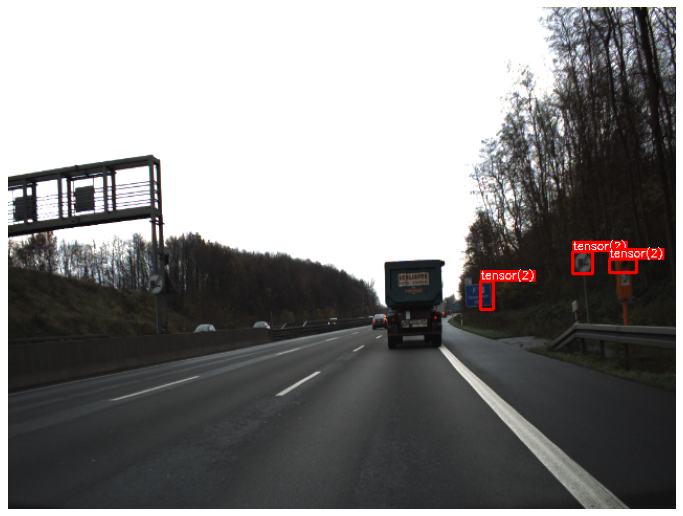

In [51]:
j = 0
visualize(images[j].permute(1,2,0).numpy() / 255., out[j]['boxes'][:3], out[j]['labels'][:3])

In [ ]:
# class Detection_model(LightningModule):
#     def __init__(self):
#         super(Detection_model, self).__init__()
#         self.model = model.train()
#     def forward(self, x, *args, **kwargs):
#         return self.model(x)
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
#         scheduler = {
#             'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
#             'monitor' : 'losses',
#         }
#         return {
#                 "optimizer": optimizer,
#                 "lr_scheduler": scheduler,
#                 }
#     def training_step(self, batch, batch_idx):
#         images, targets = batch
#         targets = [{k: v for k, v in t.items()} for t in targets]
#         loss_dict = self.model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}
#     def validation_step(self, batch, batch_idx):
#         images, targets = batch
#         targets = [{k: v for k, v in t.items()} for t in targets]
#         outputs = self.model(images, targets)
#         losses = sum(loss for loss in outputs.values())
#         return {'val_loss' : losses}
#     def validation_epoch_end(self, outputs):
#         loss_val = torch.stack([x["val_loss"] for x in outputs]).mean().detach()
#         return {'val_loss_end': loss_val}